<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [366]:
# Check for GPU
!nvidia-smi

Wed Jun 11 18:11:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.24                 Driver Version: 566.24         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              1W /   65W |     590MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [367]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.7.0+cu118


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

- Increase hidden units or hidden layers (Increase complexity)
- Train for longer
- Increase image size (more features to learn from)

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [368]:
# 1. Get data

# Libraries
import requests
import zipfile
from pathlib import Path

# Paths
data_dir = Path('data/')
images_dir = data_dir / 'pizza_steak_sushi'
zip_path = data_dir / 'pizza_steak_sushi.zip'

# ========================================================================================================

# Create Folder for Images
if not images_dir.is_dir():
    print('Creating Images Folder...')
    images_dir.mkdir(parents=True, exist_ok=True)
    print('Images Folder created!')
else:
    print('Images Folder already created... Skipping...')

# ========================================================================================================

# Download Zip File with Images from GitHub
if not zip_path.exists():
    print('Downloading ZIP File...')
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    with open(zip_path, 'wb') as file:
        file.write(request.content)
    print('ZIP File downloaded!')
else:
    print('ZIP file already exists... Skipping download.')


# Extract on Images Folder
print('Extracting images from zip...')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(path=images_dir)
print('Images extracted!')


Images Folder already created... Skipping...
ZIP file already exists... Skipping download.
Extracting images from zip...
Images extracted!


In [369]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames):1} directories and {len(filenames):2} images in '{dirpath}'.")

walk_through_dir(images_dir)

There are 2 directories and  0 images in 'data\pizza_steak_sushi'.
There are 3 directories and  0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and  0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [370]:
# Setup train and testing paths
train_dir = images_dir / 'train'
test_dir = images_dir / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

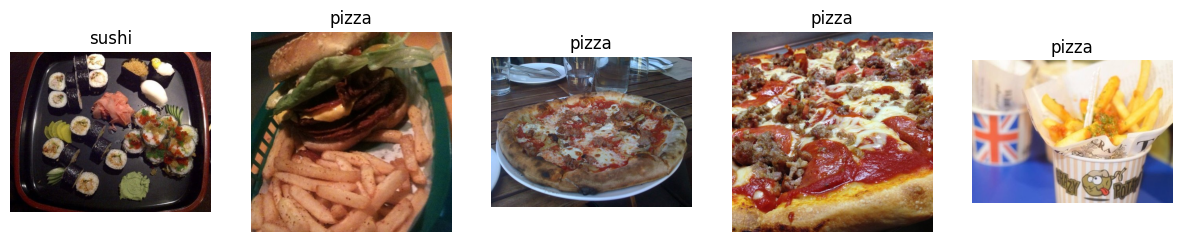

In [371]:
# Visualize an image
# Libraries
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Random Seed
MY_SEED = 42
random.seed(MY_SEED)

# Random Sampling 5 Images
K = 5
images_paths = list(images_dir.glob('*/*/*.jpg'))
rand_image_paths = random.sample(images_paths, k=K)

# Plotting
plt.figure(figsize=(15,8))
for i, img_path in enumerate(rand_image_paths):
    img = Image.open(img_path)
    plt.subplot(1,K,i+1)
    plt.imshow(img); plt.axis(False)
    plt.title(f'{img_path.parent.stem}')

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [372]:
# 3.1 Transforming data with torchvision.transforms

# Import Libraries
import torchvision
import torchvision.transforms as transforms

In [373]:
# Write transform for turning images into tensors
PIXELS = 64
my_train_transform = transforms.Compose([
    transforms.Resize(size=(PIXELS,PIXELS)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

my_test_transform = transforms.Compose([
    transforms.Resize(size=(PIXELS,PIXELS)),
    transforms.ToTensor()
]) 

my_train_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

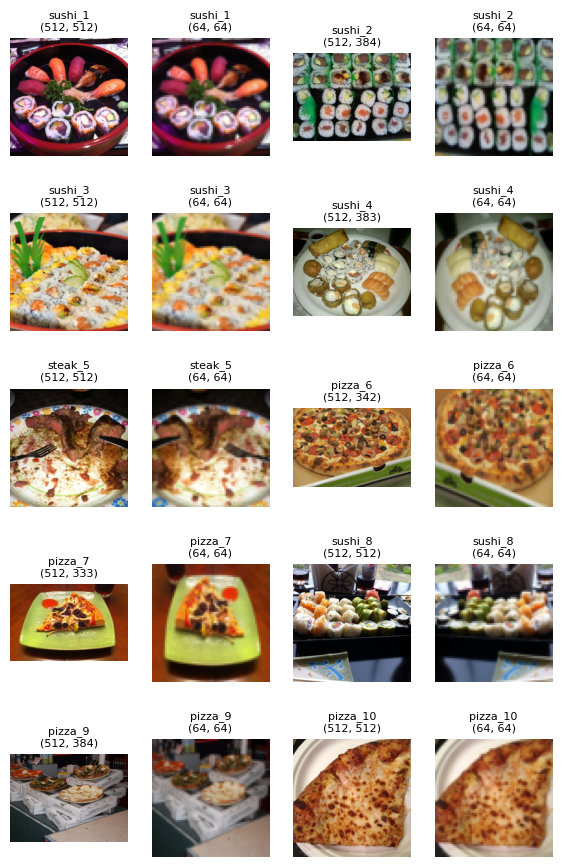

In [374]:
# Write a function to plot original vs transformed images
from typing import List
import random
def plot_original_vs_transformed_img(images_path_list: List[str], transformation: torchvision.transforms, K: int = 5):
    """This function plots and compares original vs transformed versions of K images."""
    rand_image_paths = random.sample(population=images_path_list, k=K)

    plt.figure(figsize=(7,K*1.1))
    for i, img_path in enumerate(rand_image_paths):
        img = Image.open(img_path)
        transformed_img = transformation(img)
        class_img = img_path.parent.stem; title = f'{class_img}_{i+1}'; title_size = 8

        # print(f'{K=}, {int(np.ceil(K/2))} rows, 4 cols, original_{min(K, 2*i+1)}, transf_{min(K, 2*i+2)}')
        plt.subplot(int(np.ceil(K/2)), 4, min(4*int(np.ceil(K/2)), 2*i+1)); plt.imshow(img); plt.axis(False); plt.title(f'{title}\n{img.size}', size=title_size)
        plt.subplot(int(np.ceil(K/2)), 4, min(4*int(np.ceil(K/2)), 2*i+2)); plt.imshow(transformed_img.permute(1,2,0)); plt.axis(False); plt.title(f'{title}\n{transformed_img[0,:,:].numpy().shape}', size=title_size)
        # print(rand_image_paths[i], img.size, transformed_img.shape)

plot_original_vs_transformed_img(images_paths, K=10, transformation=my_train_transform)

### Load image data using `ImageFolder`

In [375]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=my_train_transform, target_transform=None)
test_data  = datasets.ImageFolder(root=test_dir,  transform=my_test_transform, target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [376]:
# Get class names as list, dict and check # of samples
class_names = train_data.classes     # Get class names as a list
class_dict = train_data.class_to_idx # Get class names as a dict

print(f'{class_names = }')
print(f'{class_dict  = }')
print(f'{len(train_data):3} train samples.')
print(f'{len(test_data):3}  test samples.')

class_names = ['pizza', 'steak', 'sushi']
class_dict  = {'pizza': 0, 'steak': 1, 'sushi': 2}
225 train samples.
 75  test samples.


In [377]:
# Turn train and test Datasets into DataLoaders
# Libraries
import os
from torch.utils.data import DataLoader

# Parameters & DataLoaders
BATCH_SIZE = 1; NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [378]:
# How many batches of images are in our data loaders?
img, label = next(iter(train_dataloader))

print(f'Image shape: {img.shape}')
print(f'Image label: {label.shape}')
print(f'{len(train_dataloader):1} train batches.')
print(f'{len(test_dataloader):1} test bacthes.')

Image shape: torch.Size([1, 3, 64, 64])
Image label: torch.Size([1])
225 train batches.
75 test bacthes.


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [379]:
from torchinfo import summary
class TinyVGG(nn.Module):

    def __init__(self, in_img_channels: int, hidden_units: int, out_n_classes: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_img_channels, out_channels=hidden_units, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,
                      stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*(PIXELS//4)**2, out_features=out_n_classes)
        )

    
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model_0 = TinyVGG(in_img_channels=3, hidden_units=10, out_n_classes=3).to(device)
summary(model_0, input_size=[1,3,PIXELS,PIXELS])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 4. Create training and testing functions for `model_0`.

In [380]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches

  for bacth, (X,y) in enumerate(dataloader):
     
    # Send data to target device
    X, y = X.to(device), y.to(device)

    outputs = model(X); probs = torch.softmax(outputs, dim=1); preds = probs.argmax(dim=1) # 1. Forward pass
    loss = loss_fn(outputs, y); train_loss += loss.item()  # 2. Calculate and accumulate loss
    optimizer.zero_grad()                                  # 3. Optimizer zero grad 
    loss.backward()                                        # 4. Loss backward 
    optimizer.step()                                       # 5. Optimizer step
    
    train_acc += (preds == y).sum().item() / len(preds) # Calculate and accumualte accuracy metric across all batches
   
  # Adjust metrics to get average loss and average accuracy per batch
  train_loss /= len(dataloader)
  train_acc  /= len(dataloader)

  return train_loss, train_acc
  

In [381]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
    
      X, y = X.to(device), y.to(device) # Send data to target device
      
      outputs = model(X); probs = torch.softmax(outputs, dim=1); preds = probs.argmax(dim=1)     # 1. Forward pass
      test_loss += loss_fn(outputs, y).item() # 2. Calculuate and accumulate loss
      test_acc  += (preds == y).sum().item() / len(preds) # Calculate and accumulate accuracy

  # Adjust metrics to get average loss and accuracy per batch
  
  test_loss /= len(dataloader)
  test_acc  /= len(dataloader)

  return test_loss, test_acc

In [382]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1:2} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [383]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0_ = TinyVGG(in_img_channels=3, hidden_units=10, out_n_classes=3).to(device); #summary(model_0, input_size=[1,3,64,64])

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), 
                             lr=0.001)

model_0_results = train(model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                         optimizer=optimizer, loss_fn=loss_fn, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1 | train_loss: 1.1048 | train_acc: 0.3333 | test_loss: 1.0987 | test_acc: 0.3333
Epoch:  2 | train_loss: 1.0998 | train_acc: 0.3200 | test_loss: 1.0996 | test_acc: 0.3333
Epoch:  3 | train_loss: 1.1150 | train_acc: 0.4044 | test_loss: 1.0845 | test_acc: 0.4400
Epoch:  4 | train_loss: 0.9757 | train_acc: 0.5911 | test_loss: 1.0553 | test_acc: 0.4400
Epoch:  5 | train_loss: 0.9017 | train_acc: 0.5911 | test_loss: 1.0175 | test_acc: 0.4133


In [384]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(in_img_channels=3, hidden_units=10, out_n_classes=3).to(device); #summary(model_0, input_size=[1,3,64,64])

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), 
                             lr=0.001)

model_1_results = train(model_1, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                         optimizer=optimizer, loss_fn=loss_fn, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  1 | train_loss: 1.1174 | train_acc: 0.2978 | test_loss: 1.0964 | test_acc: 0.3333
Epoch:  2 | train_loss: 1.1004 | train_acc: 0.3244 | test_loss: 1.0992 | test_acc: 0.3333
Epoch:  3 | train_loss: 1.0991 | train_acc: 0.3422 | test_loss: 1.0996 | test_acc: 0.2800
Epoch:  4 | train_loss: 1.0814 | train_acc: 0.4444 | test_loss: 1.2973 | test_acc: 0.3733
Epoch:  5 | train_loss: 0.9647 | train_acc: 0.5956 | test_loss: 0.9928 | test_acc: 0.4800
Epoch:  6 | train_loss: 0.8918 | train_acc: 0.6356 | test_loss: 1.0963 | test_acc: 0.4400
Epoch:  7 | train_loss: 0.8626 | train_acc: 0.6089 | test_loss: 1.0402 | test_acc: 0.4933
Epoch:  8 | train_loss: 0.8480 | train_acc: 0.5911 | test_loss: 1.0108 | test_acc: 0.4000
Epoch:  9 | train_loss: 0.8153 | train_acc: 0.6133 | test_loss: 1.0072 | test_acc: 0.4533
Epoch: 10 | train_loss: 0.7832 | train_acc: 0.6444 | test_loss: 1.2662 | test_acc: 0.4267
Epoch: 11 | train_loss: 0.7525 | train_acc: 0.6178 | test_loss: 1.0122 | test_acc: 0.5333
Epoch: 12 

In [385]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TinyVGG(in_img_channels=3, hidden_units=10, out_n_classes=3).to(device); #summary(model_0, input_size=[1,3,64,64])

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), 
                             lr=0.001)

model_2_results = train(model_2, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                         optimizer=optimizer, loss_fn=loss_fn, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  1 | train_loss: 1.1174 | train_acc: 0.2978 | test_loss: 1.0964 | test_acc: 0.3333
Epoch:  2 | train_loss: 1.1004 | train_acc: 0.3244 | test_loss: 1.0992 | test_acc: 0.3333
Epoch:  3 | train_loss: 1.0991 | train_acc: 0.3422 | test_loss: 1.0996 | test_acc: 0.2800
Epoch:  4 | train_loss: 1.0814 | train_acc: 0.4444 | test_loss: 1.2973 | test_acc: 0.3733
Epoch:  5 | train_loss: 0.9647 | train_acc: 0.5956 | test_loss: 0.9928 | test_acc: 0.4800
Epoch:  6 | train_loss: 0.8918 | train_acc: 0.6356 | test_loss: 1.0963 | test_acc: 0.4400
Epoch:  7 | train_loss: 0.8626 | train_acc: 0.6089 | test_loss: 1.0402 | test_acc: 0.4933
Epoch:  8 | train_loss: 0.8480 | train_acc: 0.5911 | test_loss: 1.0108 | test_acc: 0.4000
Epoch:  9 | train_loss: 0.8153 | train_acc: 0.6133 | test_loss: 1.0072 | test_acc: 0.4533
Epoch: 10 | train_loss: 0.7832 | train_acc: 0.6444 | test_loss: 1.2662 | test_acc: 0.4267
Epoch: 11 | train_loss: 0.7525 | train_acc: 0.6178 | test_loss: 1.0122 | test_acc: 0.5333
Epoch: 12 

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [386]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_3 = TinyVGG(in_img_channels=3, hidden_units=20, out_n_classes=3).to(device); #summary(model_0, input_size=[1,3,64,64])

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), 
                             lr=0.001)

model_3_results = train(model_3, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                         optimizer=optimizer, loss_fn=loss_fn, epochs=20)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:  1 | train_loss: 1.0876 | train_acc: 0.3956 | test_loss: 1.0682 | test_acc: 0.4133
Epoch:  2 | train_loss: 1.0090 | train_acc: 0.5111 | test_loss: 1.1125 | test_acc: 0.4133
Epoch:  3 | train_loss: 0.9477 | train_acc: 0.5956 | test_loss: 0.9793 | test_acc: 0.4667
Epoch:  4 | train_loss: 0.8844 | train_acc: 0.6089 | test_loss: 1.0124 | test_acc: 0.4000
Epoch:  5 | train_loss: 0.8721 | train_acc: 0.6089 | test_loss: 0.9819 | test_acc: 0.5200
Epoch:  6 | train_loss: 0.8606 | train_acc: 0.6267 | test_loss: 0.9825 | test_acc: 0.4667
Epoch:  7 | train_loss: 0.8254 | train_acc: 0.6444 | test_loss: 1.0140 | test_acc: 0.4667
Epoch:  8 | train_loss: 0.7542 | train_acc: 0.6800 | test_loss: 1.0255 | test_acc: 0.4533
Epoch:  9 | train_loss: 0.7305 | train_acc: 0.6622 | test_loss: 1.0765 | test_acc: 0.4933
Epoch: 10 | train_loss: 0.6759 | train_acc: 0.7022 | test_loss: 1.0292 | test_acc: 0.4800
Epoch: 11 | train_loss: 0.6373 | train_acc: 0.7422 | test_loss: 1.0750 | test_acc: 0.4933
Epoch: 12 

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [387]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
zip_path = data_path / 'pizza_steak_sushi_20_percent.zip'

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
if not zip_path.exists():
    print('Downloading ZIP File...')
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip')
    with open(zip_path, 'wb') as file:
        file.write(request.content)
    print('ZIP File downloaded!')
else:
    print('ZIP file already exists... Skipping download.')

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

data\pizza_steak_sushi_20_percent directory exists.
ZIP file already exists... Skipping download.
Unzipping pizza, steak, sushi 20% data...


In [388]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and  0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and  0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 58 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and  0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 154 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 146 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 150 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images... 

In [389]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [390]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets
train_data_20 = datasets.ImageFolder(root=train_data_20_percent_path, transform=my_train_transform, target_transform=None)
test_data_20 = datasets.ImageFolder(root=test_data_20_percent_path, transform=my_test_transform, target_transform=None)

# Create dataloaders
BATCH_SIZE = 32
train_dataloader_20 = DataLoader(dataset=train_data_20, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_20 =  DataLoader(dataset=test_data_20, batch_size=BATCH_SIZE, shuffle=False)

print(f'{'-'*40}\n{len(train_data_20.samples)} train samples.')
print(f'{len(test_data_20.samples)} test samples.')
print(f'{'-'*40}\n{len(train_dataloader_20)} train batches of {BATCH_SIZE} samples each one.')
print(f'{len(test_dataloader_20)} test batches of {BATCH_SIZE} samples each one.')

----------------------------------------
450 train samples.
150 test samples.
----------------------------------------
15 train batches of 32 samples each one.
5 test batches of 32 samples each one.


In [391]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_4 = TinyVGG(in_img_channels=3, hidden_units=20, out_n_classes=3).to(device); #summary(model_0, input_size=[1,3,64,64])

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), 
                             lr=0.001)

model_4_results = train(model_4, train_dataloader=train_dataloader_20, test_dataloader=test_dataloader_20,
                         optimizer=optimizer, loss_fn=loss_fn, epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  1 | train_loss: 1.1045 | train_acc: 0.3375 | test_loss: 1.1011 | test_acc: 0.2875
Epoch:  2 | train_loss: 1.0941 | train_acc: 0.4167 | test_loss: 1.0819 | test_acc: 0.4188
Epoch:  3 | train_loss: 1.0596 | train_acc: 0.4125 | test_loss: 0.9622 | test_acc: 0.5153
Epoch:  4 | train_loss: 0.8927 | train_acc: 0.5938 | test_loss: 0.9208 | test_acc: 0.5733
Epoch:  5 | train_loss: 0.8795 | train_acc: 0.5729 | test_loss: 0.8985 | test_acc: 0.5540
Epoch:  6 | train_loss: 0.8293 | train_acc: 0.6646 | test_loss: 0.9114 | test_acc: 0.5943
Epoch:  7 | train_loss: 0.8575 | train_acc: 0.6292 | test_loss: 0.9490 | test_acc: 0.5563
Epoch:  8 | train_loss: 0.8566 | train_acc: 0.6417 | test_loss: 0.9192 | test_acc: 0.5881
Epoch:  9 | train_loss: 0.8389 | train_acc: 0.6521 | test_loss: 0.8955 | test_acc: 0.6102
Epoch: 10 | train_loss: 0.8143 | train_acc: 0.6562 | test_loss: 0.9345 | test_acc: 0.5375
Epoch: 11 | train_loss: 0.8110 | train_acc: 0.6438 | test_loss: 0.9274 | test_acc: 0.5699
Epoch: 12 

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [398]:
custom_image_path = data_path / '04-pizza-dad.jpeg'
import torchvision
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
transformation = transforms.Compose([transforms.Resize(size=(PIXELS,PIXELS))])
custom_image_transformed = transformation(custom_image).unsqueeze(dim=0)
print(f'Custom Image Shape: {custom_image_transformed.shape}')
print(f'Custom Image dtype: {custom_image_transformed.dtype}')

Custom Image Shape: torch.Size([1, 3, 64, 64])
Custom Image dtype: torch.float32


Text(0.5, 1.0, 'Predicted: pizza')

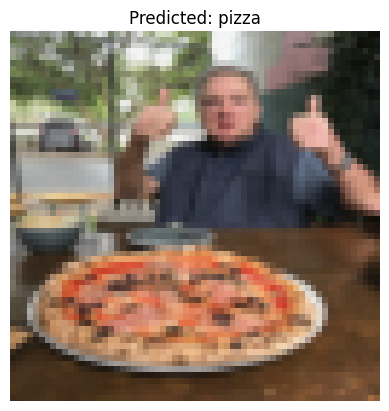

In [412]:
model_4.eval()
with torch.inference_mode():
    custom_image_output = model_4(custom_image_transformed.to(device))
    custom_image_probs = torch.softmax(custom_image_output, dim=1)
    custom_image_preds = custom_image_probs.argmax(dim=1).item()
plt.imshow(custom_image_transformed.squeeze(dim=0).permute(1,2,0)); plt.axis(False); 
title = class_names[custom_image_preds]
plt.title(f'Predicted: {title}')